# GradientBoostingClassifier w/ GridSearchCV (Cancer Dataset) #

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

import warnings 
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Read in data, treating "?" as NaN and trimming whitespace
df = pd.read_csv(
    url, header=None
    , names=columns
    , na_values="?"
    , skipinitialspace=True
)

# Quick look at the data
df.shape
df.head()
df.info()

(32561, 15)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [3]:
# Now you can inspect missing values
df.isnull().sum().sort_values(ascending=False)

occupation        1843
workclass         1836
native-country     583
age                  0
fnlwgt               0
education            0
education-num        0
marital-status       0
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
income               0
dtype: int64

In [4]:
# Drop rows with missing values for simplicity
df_clean = df.dropna()
df_clean.shape
df_clean.info()

(30162, 15)

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   fnlwgt          30162 non-null  int64 
 3   education       30162 non-null  object
 4   education-num   30162 non-null  int64 
 5   marital-status  30162 non-null  object
 6   occupation      30162 non-null  object
 7   relationship    30162 non-null  object
 8   race            30162 non-null  object
 9   sex             30162 non-null  object
 10  capital-gain    30162 non-null  int64 
 11  capital-loss    30162 non-null  int64 
 12  hours-per-week  30162 non-null  int64 
 13  native-country  30162 non-null  object
 14  income          30162 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
# Identify categorical columns
categorical_cols = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'native-country'
]

# One-hot encode categoricals, drop_first avoids collinearity
df_encoded = pd.get_dummies(
    df_clean
    , columns=categorical_cols
    , drop_first=True
)

# Convert target variable to binary
df_encoded['income'] = df_encoded['income'].map(
    {'<=50K': 0, '>50K': 1}
)

df_encoded.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,215646,9,0,0,40,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,53,234721,7,0,0,40,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4,28,338409,13,0,0,40,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
# Separate features and target
X = df_encoded.drop('income', axis=1)
y = df_encoded['income']

X.shape, y.shape

((30162, 96), (30162,))

In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
    , random_state=27
    , stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24129, 96), (6033, 96), (24129,), (6033,))

In [8]:
# Initialize XGBoost classifier

xgb_clf = XGBClassifier(
    eval_metric='logloss'           # Required for sklearn compatibility
    , random_state=27
    , n_jobs=-1                       # Use all CPU cores for training
)

In [9]:
# Going to fit the base model (even though we are using the GridCV/ best_model, want to compare it after;)

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

In [10]:
# Set up parameter grid for GridSearchCV (with XGBoost hyperparameters)
param_grid = {
    'n_estimators': [50, 100]         # Number of boosting rounds
    , 'learning_rate': [0.05, 0.1]    # Step size shrinkage
    , 'max_depth': [3, 5, 7, 9]       # Maximum tree depth
    , 'subsample': [0.8, 1.0]         # Row sampling
    , 'min_child_weight': [1, 3]      # Minimum sum of instance weight (child node)
    , 'gamma': [0, 0.2]               # Minimum loss reduction for a split
}

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_clf
    , param_grid=param_grid
    , cv=3
    , scoring='accuracy'
    , n_jobs=-1
    , verbose=1
)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.2], 'learning_rate': [0.05, 0.1],
                         'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3],
                         'n_estimators': [50, 100], 'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [11]:
# Retrieve best params & best score;

grid_search.best_params_
grid_search.best_score_

{'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 1.0}

0.8684155994860956

In [12]:
# Use best_estimator_ to build a 'best model'
best_xgb = grid_search.best_estimator_

# Predict on test set
y_pred = best_xgb.predict(X_test)

In [13]:
# See how the best boosted model does on test data:

best_xgb.fit(X_train, y_train)
best_xgb.score(X_test, y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, ...)

0.8713741090667992

In [14]:
# Eval performance of base to see how much better the 'best_model' is;
y_pred_base = xgb_clf.predict(X_test)
accuracy_score(y_test, y_pred_base)

0.8695508039118184

In [15]:
# Evaluate performance
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

0.8713741090667992

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4531
           1       0.78      0.67      0.72      1502

    accuracy                           0.87      6033
   macro avg       0.84      0.80      0.82      6033
weighted avg       0.87      0.87      0.87      6033



In [16]:
print("Confusion Matrix, Best Model:")
confusion_matrix(y_test, y_pred)
print('\n')
print("Confusion Matrix, Base Model:")
confusion_matrix(y_test, y_pred_base)

Confusion Matrix, Best Model:


array([[4257,  274],
       [ 502, 1000]])



Confusion Matrix, Base Model:


array([[4237,  294],
       [ 493, 1009]])

In [18]:
# Evaluate performance
accuracy_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

0.8713741090667992

array([[4257,  274],
       [ 502, 1000]])

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4531
           1       0.78      0.67      0.72      1502

    accuracy                           0.87      6033
   macro avg       0.84      0.80      0.82      6033
weighted avg       0.87      0.87      0.87      6033



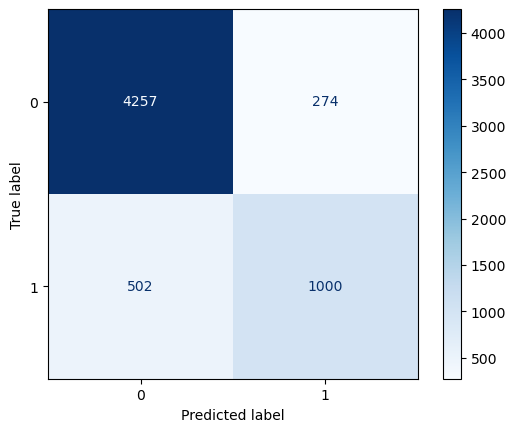

In [19]:
ConfusionMatrixDisplay.from_estimator(
    best_xgb, X_test, y_test, cmap='Blues'
);

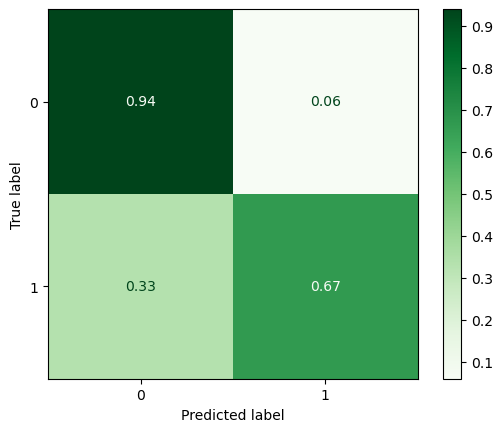

In [20]:
ConfusionMatrixDisplay.from_estimator(
    best_xgb, X_test, y_test, normalize='true', cmap='Greens'
);

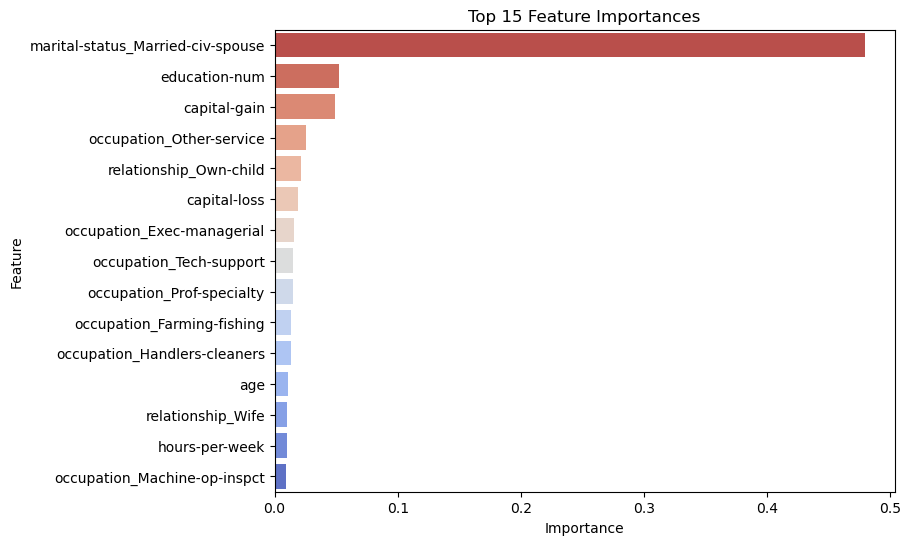

In [31]:
# Feature Importance
importances = grid_search.best_estimator_.feature_importances_
feat_names = X.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances[indices][:top_n]
    , y=np.array(feat_names)[indices][:top_n]
    , palette='coolwarm_r'
)
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show();